# How to use the Orthogonalisation feature in `deepcure` package
Again we are going to simulate and then fit a Promotion Time Cure model, precisely this time, we assume
$$S_p(t|\mathbf{x}) = \exp(-\exp(\eta(\mathbf{x}))F(t))$$

where $\eta(\mathbf{x}) = \eta^{lin}(\mathbf{x})+\eta^{non}(\mathbf{x})$, where $\eta^{lin}(\mathbf{x})= -1+\frac{2}{1}x_1+\frac{2}{2}x_2+\frac{2}{3}x_3$ and $\eta^{non}(\mathbf{x})=-0.8x_{1}^2+4x_{2}^3-0.75\cos(x_{3})$. Moreover, $\eta^{non}(\mathbf{x})$ is projected to the orthogonal complement of $\eta^{lin}(\mathbf{x})$.

In [26]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from deepcure.simulations import simDF_PTM
from deepcure.models import DeepPTM

## Simulate data
We simulate 10.000 data points from a PTM model with the following parameters with $F(t)=1-\exp(-t)$ (exponential distribution with rate 1). We can still use the `simDF_PTM` function as follows:

In [27]:
n_inds = 10000
end_study = 3
df_sim = simDF_PTM(scenario=4, n=n_inds, end_of_study=end_study) # scenario 4 considers a linear and non-linear predictor

Number of subjects: 10000
Number of events: 3628
Event rate (#events/n): 0.3628


## Preprocess data
As before, the steps are simple. We need to define the breakpoints. Also, we need to transform the data into TensorFlow format.

In [28]:
# create break_val equal to the quantiles of time_event when label_event is 1
break_val = df_sim["time_event"][df_sim["label_event"]==1].values
break_val  = np.quantile(break_val,[0, 0.2, 0.4, 0.6, 0.8, 1])
break_val[0] = 0
break_val[-1] = df_sim["time_event"].max()
break_val = tf.convert_to_tensor(break_val, dtype=tf.float64)

# Data to tf.Tensor
# get the number of columns in the df_sim dataframe that starts with 'x'
num_covs = len(df_sim.columns[df_sim.columns.str.startswith('x')])
x_data = tf.convert_to_tensor(df_sim.iloc[:, 0:num_covs].values.reshape(-1, num_covs), dtype=tf.float64)
label_data = tf.convert_to_tensor(df_sim["label_event"], dtype=tf.float64)
time_data = tf.convert_to_tensor(df_sim["time_event"], dtype=tf.float64)

df_sim_tensor = {'x':x_data,
        'label_event':label_data,
        'time_event':time_data}

We can now split the data into training and test sets. We simple use the first 80% of the data for training and the rest for testing.

In [29]:
# split df_sim_tensor data into train and validation sets
train_data = {'x':df_sim_tensor['x'][:int(0.8*n_inds)],
        'label_event':df_sim_tensor['label_event'][:int(0.8*n_inds)],
        'time_event':df_sim_tensor['time_event'][:int(0.8*n_inds)]}
valid_data = {'x':df_sim_tensor['x'][int(0.8*n_inds):],
        'label_event':df_sim_tensor['label_event'][int(0.8*n_inds):],
        'time_event':df_sim_tensor['time_event'][int(0.8*n_inds):]}

## Define the model
We fit two models: one without orthogalisation and one with orthogalisation. We use the same architecture for both.

In [31]:
# create DeepPTM model without orthogonalisation and piecewise Exponential F
n_epochs = 500
b_size = 512
num_units = 64
st_decay = 500 
rt_decay = 0.5
ini_lr = 0.01
stack_eta_no_orth = [tf.keras.layers.Dense(num_units, activation='relu', dtype=tf.float64),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(num_units, activation='relu', dtype=tf.float64),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1, activation='linear', dtype=tf.float64, name = "eta")]
model_no_orth = DeepPTM(stack_eta = stack_eta_no_orth, t_func='pe', break_val=break_val) # define the model
# compile the model
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=ini_lr, decay_steps=st_decay, decay_rate=rt_decay)
model_no_orth.compile(tf.keras.optimizers.RMSprop(learning_rate=lr))
# define the callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Fit the model
model_no_orth.fit(train_data, epochs=n_epochs, batch_size=b_size, validation_data=valid_data, callbacks=[early_stopping], verbose=0)

Now, let's define and train the model with orthogonalisation:

In [32]:
# create DeepPTM model with orthogonalisation and piecewise Exponential F
stack_eta_with_orth = [tf.keras.layers.Dense(num_units, activation='relu', dtype=tf.float64, use_bias=False),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(num_units, activation='relu', dtype=tf.float64),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(1, activation='linear', dtype=tf.float64, name = "eta", use_bias=False)]
model_with_orth = DeepPTM(stack_eta = stack_eta_with_orth, t_func='pe', break_val=break_val, cols_ortho='all') # define the model
# compile the model
lr = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=ini_lr, decay_steps=st_decay, decay_rate=rt_decay)
model_with_orth.compile(tf.keras.optimizers.RMSprop(learning_rate=lr))
# define the callback for early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Fit the model
model_with_orth.fit(train_data, epochs=n_epochs, batch_size=b_size, validation_data=valid_data, callbacks=[early_stopping], verbose=0)

## Results
Let's first check how similar the predictors $\eta$ are. To do so, we can get the corresponding predictions and then plot them with respect to the true values.

In [33]:
eta_est_no_orth = model_no_orth.eta_predict(valid_data)
eta_est_with_orth = model_with_orth.eta_predict(valid_data)

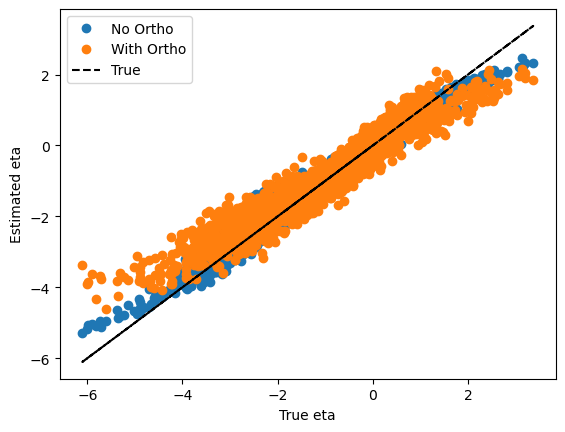

In [34]:
# plot both eta_est_no_orth, eta_est_with_orth versus df_sim['eta']
plt.plot(df_sim['eta'][int(0.8*n_inds):], eta_est_no_orth, 'o', label='No Ortho')
plt.plot(df_sim['eta'][int(0.8*n_inds):], eta_est_with_orth, 'o', label='With Ortho')
plt.plot(df_sim['eta'][int(0.8*n_inds):], df_sim['eta'][int(0.8*n_inds):], 'k--', label='True')
plt.xlabel('True eta')
plt.ylabel('Estimated eta')
plt.legend()
plt.show()

As expected, the estimated $\eta$ are very close to each other. Now, let's check the linear part of the predictor. Remember the true values were $-1+\frac{2}{1}x_1+\frac{2}{2}x_2+\frac{2}{3}x_3$.

In [35]:
betas = model_with_orth.get_layer('out_lin_layer').get_weights()[0]
intercept = model_with_orth.get_layer('out_lin_layer').get_weights()[1]
print("intercept:",intercept,"\nbetas:", betas.flatten())

intercept: [-0.86701843] 
betas: [1.72628947 0.97898478 0.67375877]
